# Titanic Machine Learning

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## Loading Immediate Packages and Data

In [1]:
# import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import os # directory stuff
import matplotlib.pyplot as plt # plotting

# set dir
os.chdir("/Users/chethanjujjavarapu/GitHub/Sandbox/Data_Science/Kaggle/Titanic")

# load data
gender_submission = pd.read_csv("Data/gender_submission.csv")
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [2]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Exploration

### Data Structure

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Total # of Male, Female, and Total Patients

In [4]:
## structure of the training data (male, female, total patients)

total=train.shape[0]
male=train[train.Sex == "male"].shape[0]
female=train[train.Sex == "female"].shape[0]

print(total,male,female)

891 577 314


### Percent of Patients with Missing Information in Training Data

#### Age

In [5]:
## structure of the training data (% of nan for age)
nan_age = train.Age.isnull().sum()
round((nan_age/total)*100,2)

19.87

#### Sex

In [6]:
nan_age = train.Sex.isnull().sum()
round((nan_age/total)*100,2)

0.0

#### Pclass

In [7]:
nan_age = train.Pclass.isnull().sum()
round((nan_age/total)*100,2)

0.0

#### SibSp

In [8]:
nan_age = train.SibSp.isnull().sum()
round((nan_age/total)*100,2)

0.0

#### Parch

In [9]:
nan_age = train.Parch.isnull().sum()
round((nan_age/total)*100,2)

0.0

#### Cabin

In [10]:
nan_age = train.Cabin.isnull().sum()
round((nan_age/total)*100,2)

77.1

#### Embarked

In [11]:
nan_age = train.Embarked.isnull().sum()
round((nan_age/total)*100,2)

0.22

### Breakdown of Survived Counts for Male and Female

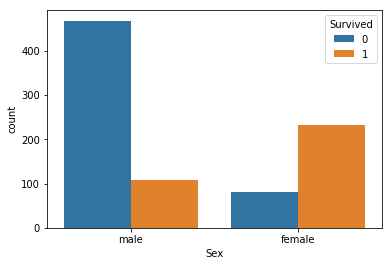

In [12]:
## survival indicator vs. gender
surv_sex = sns.countplot(x="Sex",
                          hue="Survived",
                          data=train)
plt.show()

"Gender" seems to be related to "Survival" as more Males did not survive, while the opposite trend is observed for Females.

### Breakdown of Survived Counts for Classes

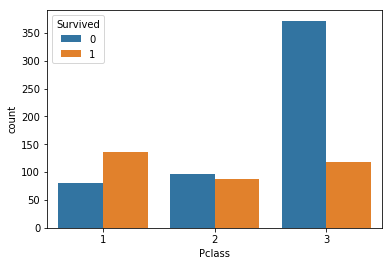

In [13]:
## survival indicator vs. class
surv_class = sns.countplot(x="Pclass",
                          data=train,
                          hue="Survived")
plt.show()

### Breakdown of Survived Counts for Embarks

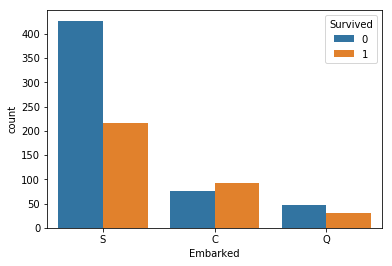

In [14]:
## survival vs. embark
surv_embark = sns.countplot(x="Embarked",
                          data=train,
                          hue="Survived")
plt.show()

### Age Distribution for Survived and Non-Survived

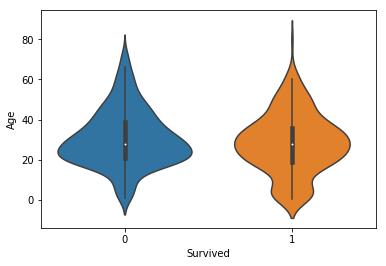

In [15]:
## age distribution for survived and non-survived
age_boxp = sns.violinplot(x="Survived",y="Age",data=train)
plt.show()

Age could be a confounding factor. For example, elderly women could have died from poor health before even being saved. This idea comes from a thought, no evidence in the data to back it up. However, that technically would be factor to indicate if you will survive: if your young, you have a better chance vs. elderly.

### Age Distribution for Survived and Non-Survived Separated by Gender

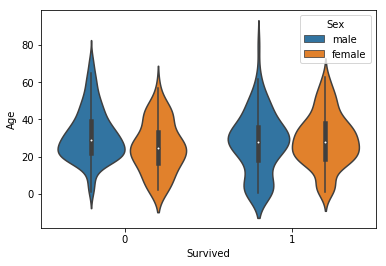

In [16]:
## age distribution for survived and non-survived
age_boxp = sns.violinplot(x="Survived",y="Age",hue="Sex",data=train)
plt.show()

Doesn't seem to have a visually distinct difference in Age distribution between Gender between Survived and Non-Survived.

## Preparing Data

### Subset Dataframe for Features of Interest

Based on priori, I believe that features: Pclass, Sex, Age, SibSp, Parch, and Embarked will be sufficient to predict survival. I exclude Fare because I believe Pclass can represent this information more easily. I exclude Name because the only information that could be collected would be the surname, which could indicate family members (eg. Mr., Mrs., Miss), but SibSp and Parch account for that factor. I exclude Cabin because there are Na's in the data, so I would like to first see if keep only data with values can result in an adequete classifier or not. I don't think Ticket will contain any useful information.

In [27]:
# train data
train_subset = train.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin"], axis=1)
# test data
test_subset = test.drop(["Name", "Ticket", "Fare", "Cabin"], axis=1)

### Convert NA's to a computable value

As shown in exploration, the columns with NA values are Age, Embarked

#### Age: replace NA with -1

In [28]:
# train
train_subset.Age.fillna(-1,inplace=True)
# test
test_subset.Age.fillna(-1,inplace=True)

#### Embarked: replace NA with N

In [29]:
# train
train_subset.Embarked.fillna("N",inplace=True)
# test
test_subset.Embarked.fillna("N",inplace=True)

### Encoding Non-Numerical values

In [30]:
# import preprocessing package
from sklearn import preprocessing

# train
## get features
features = train_subset.columns
## loop through each feature
for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(train_subset.loc[:,feature])
    train_subset.loc[:,feature] = le.transform(train_subset.loc[:,feature])
## after preprocessing
train_subset.head()

# test
## get features
features = list(test_subset.columns)
features.remove("PassengerId")
## loop through each feature
for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(test_subset.loc[:,feature])
    test_subset.loc[:,feature] = le.transform(test_subset.loc[:,feature])

## Splitting Training Data to Train and Test

In [31]:
# import package
from sklearn.model_selection import train_test_split

X_all = train_subset.drop('Survived', axis=1)
y_all = train_subset['Survived']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=23)

## Building the Machine Learning Model

I will apply the random forest classifier algorithm and perform cross-validation

In [32]:
# import package
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create random forest classifier (rfc) object
rfc = RandomForestClassifier(max_features="auto")

# create random forests using train data
rfc = rfc.fit(X_train, y_train)

# check accuracy of the model using test data
predictions = rfc.predict(X_test)
print(round(accuracy_score(y_test, predictions),3))

0.804


## Validation with KFold

In [24]:
from sklearn.cross_validation import KFold

def run_kfold(rfc):
    kf = KFold(len(X_all), n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        rfc.fit(X_train, y_train)
        predictions = rfc.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(rfc)

Fold 1 accuracy: 0.6777777777777778
Fold 2 accuracy: 0.7865168539325843
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.797752808988764
Fold 5 accuracy: 0.8089887640449438
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.7752808988764045


/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold 8 accuracy: 0.7415730337078652
Fold 9 accuracy: 0.8314606741573034
Fold 10 accuracy: 0.7640449438202247
Mean Accuracy: 0.7767665418227215


## Predicting on Test Data

In [25]:
test_subset.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,892,2,1,45,0,0,7,1
1,893,2,0,61,1,0,7,2
2,894,1,1,75,0,0,7,1
3,895,2,1,35,0,0,7,2
4,896,2,0,28,1,1,7,2


In [26]:
# get passengerIDs
ids = test_subset.loc[:,"PassengerId"]

# perform prediction
predictions = rfc.predict(test_subset.drop("PassengerId", axis=1))

# create output
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })

output.to_csv("Data/submission.csv", index=False)

output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
